In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

import time, copy, os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
from collections import namedtuple

# Step 1: create dataset

In [3]:
transform_high = transforms.Compose(
    [transforms.Resize((240, 240)),
     transforms.ToTensor()])

transform_low = transforms.Compose(
    [transforms.Resize((120, 120)),
     transforms.Resize((240, 240), interpolation = Image.BILINEAR),
     transforms.ToTensor()])

In [4]:
!mkdir data

trainset_high = torchvision.datasets.VOCSegmentation(root='./data/Segmentation/train/high', image_set='train',
                                        download=True, transform=transform_high)

trainset_low = torchvision.datasets.VOCSegmentation(root='./data/Segmentation/train/low', image_set='train',
                                        download=True, transform=transform_low)

testset_high = torchvision.datasets.VOCSegmentation(root='./data/Segmentation/val/high', image_set='val',
                                        download=True, transform=transform_high)

testset_low = torchvision.datasets.VOCSegmentation(root='./data/Segmentation/val/low', image_set='val',
                                        download=True, transform=transform_low)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/Segmentation/train/high/VOCtrainval_11-May-2012.tar to ./data/Segmentation/train/high


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/Segmentation/train/low/VOCtrainval_11-May-2012.tar to ./data/Segmentation/train/low


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/Segmentation/val/high/VOCtrainval_11-May-2012.tar to ./data/Segmentation/val/high


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./data/Segmentation/val/low/VOCtrainval_11-May-2012.tar to ./data/Segmentation/val/low


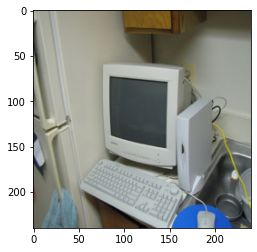

In [5]:
plt.imshow(trainset_high[1][0].permute(1, 2, 0))
plt.show()

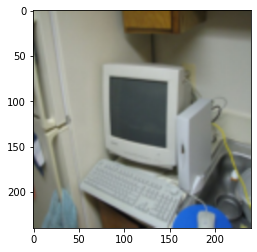

In [6]:
plt.imshow(trainset_low[1][0].permute(1, 2, 0))
plt.show()

In [7]:
train_data = []
train_labels = []

for i in range(len(trainset_high)):
  label = trainset_high[i][0]
  img = trainset_low[i][0]
  train_labels.append(label)
  train_data.append(img)

In [8]:
test_data = []
test_labels = []

for i in range(len(testset_high)):
  label = testset_high[i][0]
  img = testset_low[i][0]
  test_labels.append(label)
  test_data.append(img)

In [9]:
train_data_ts = torch.stack(train_data)
test_data_ts = torch.stack(test_data)
train_labels_ts = torch.stack(train_labels)
test_labels_ts = torch.stack(test_labels)

train_dataset = TensorDataset(train_data_ts, train_labels_ts)
test_dataset = TensorDataset(test_data_ts, test_labels_ts)

In [10]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
  }

In [11]:
dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 1464, 'val': 1449}


In [12]:
inputs, classes= next(iter(dataloaders['train']))
inputs.shape

torch.Size([16, 3, 240, 240])

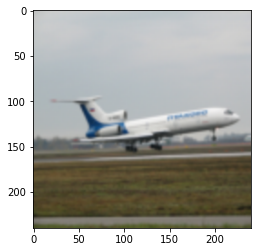

In [13]:
plt.imshow(inputs[3].permute(1, 2, 0))
plt.show()

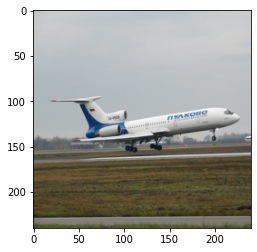

In [14]:
plt.imshow(classes[3].permute(1, 2, 0))
plt.show()

# Step 2: create an initial model

In [269]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        return x

In [270]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [271]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
  )
)


In [272]:
summary(model, (3, 240, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]          15,616
              ReLU-2         [-1, 64, 240, 240]               0
            Conv2d-3         [-1, 32, 240, 240]          51,232
              ReLU-4         [-1, 32, 240, 240]               0
            Conv2d-5          [-1, 3, 240, 240]           2,403
              ReLU-6          [-1, 3, 240, 240]               0
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.66
Forward/backward pass size (MB): 87.01
Params size (MB): 0.26
Estimated Total Size (MB): 87.94
----------------------------------------------------------------


In [273]:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.MSELoss(reduction='sum')

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15

In [274]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
      super(VGGPerceptualLoss, self).__init__()
      self.blocks_names = {0: 'relu1_2', 1: 'relu2_2', 2: 'relu3_3', 3: 'relu4_3'}
      blocks = []
      blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval()) #relu1_2
      blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval()) #relu2_2
      blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval()) #relu3_3
      blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval()) #relu4_3
      for bl in blocks:
          for p in bl.parameters():
              p.requires_grad = False
            
      self.blocks = torch.nn.ModuleList(blocks)

    def forward(self, input, target):
      loss = 0.0
      loss_components = {}
      x = input
      y = target
      for i in range(len(self.blocks)):
        block = self.blocks[i]
        name = self.blocks_names[i]
        x = block(x)
        y = block(y)
        if name == 'relu2_2':
          mse = 0.3*(((x - y)*(x - y)).sum().data)
        else:
          mse = ((x - y)*(x - y)).sum().data
        loss_components[name] = mse
        loss += mse
      return loss, loss_components

In [275]:
vgg_model = VGGPerceptualLoss().to(device)
print(vgg_model)

VGGPerceptualLoss(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (1): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (2): Sequential(
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

# Step 3: Training the model

In [276]:
def train_model(model, vgg_model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    results = {'loss_train':[], 'loss_val':[], 
               'mse_train': [], 'mse_val': [], 
               'perceptual_loss_train': [], 'perceptual_loss_val': []}

    loss_components_vgg = {'relu1_2': 0, 'relu2_2': 0, 'relu3_3': 0, 'relu4_3': 0}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_mse = 0.0
            running_perceptual_loss = 0.0

            for name in loss_components_vgg.keys():
              loss_components_vgg[name] = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    mse_loss = criterion(outputs, labels)
                    perceptual_loss, loss_components = vgg_model(outputs, labels)
                    loss = mse_loss + perceptual_loss
                    
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                for name, val in loss_components.items():
                  loss_components_vgg[name] += val

                running_loss += loss
                running_mse += mse_loss.item()
                running_perceptual_loss += perceptual_loss.item()
                
            # epoch calculations
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mse = running_mse / dataset_sizes[phase]
            epoch_perceptual_loss = running_perceptual_loss / dataset_sizes[phase]

            for name in loss_components.keys():
              loss_components_vgg[name] = loss_components_vgg[name] / dataset_sizes[phase]

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()
                results['loss_train'].append(epoch_loss.item())
                results['mse_train'].append(epoch_mse)
                results['perceptual_loss_train'].append(epoch_perceptual_loss)
            
            else:
              results['loss_val'].append(epoch_loss.item())
              results['mse_val'].append(epoch_mse)
              results['perceptual_loss_val'].append(epoch_perceptual_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} MSE Loss: {epoch_mse:.4f}')
            print(f'Perceptual losses:')
            for name in loss_components.keys():
              print(f'{name}: {loss_components_vgg[name].item()}')
            print()

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, results

In [277]:
model, results = train_model(model, vgg_model, dataloaders, criterion, optimizer_ft, 
                       exp_lr_scheduler,num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 3944323.7500 MSE Loss: 3031.4017
Perceptual losses:
relu1_2: 368213.25
relu2_2: 479066.75
relu3_3: 2664791.5
relu4_3: 429220.53125

val Loss: 3216771.7500 MSE Loss: 625.1705
Perceptual losses:
relu1_2: 263854.28125
relu2_2: 401392.0
relu3_3: 2185196.0
relu4_3: 365704.0625


Epoch 1/14
----------
train Loss: 2616899.2500 MSE Loss: 441.0188
Perceptual losses:
relu1_2: 208911.375
relu2_2: 325180.96875
relu3_3: 1775576.125
relu4_3: 306789.46875

val Loss: 2362659.0000 MSE Loss: 374.5353
Perceptual losses:
relu1_2: 191642.15625
relu2_2: 294366.59375
relu3_3: 1598399.125
relu4_3: 277876.5625


Epoch 2/14
----------
train Loss: 2121552.2500 MSE Loss: 335.8451
Perceptual losses:
relu1_2: 171760.875
relu2_2: 262155.5625
relu3_3: 1432509.125
relu4_3: 254790.9375

val Loss: 1999445.2500 MSE Loss: 317.2547
Perceptual losses:
relu1_2: 168101.90625
relu2_2: 248858.109375
relu3_3: 1344297.25
relu4_3: 237870.8125


Epoch 3/14
----------
train Loss: 1847753.2500 MSE Lo

When we trained the models with the same weights to each perceptual loss we saw that the component of "relu2_2" doesn't change meaningfully and hasn't big influence on the loss. We decided to reduce the weight of this component to 0.3 and we saw that the gap between the train and test is lower and the mse is lower.

# Step 4: Summary

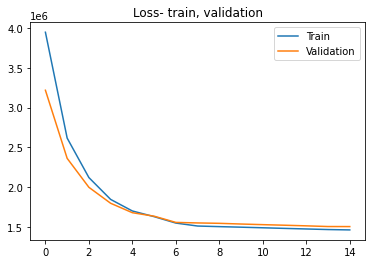

In [278]:
plt.plot(results['loss_train'], label="Train")
plt.plot(results['loss_val'], label= "Validation")
plt.legend()
plt.title('Loss- train, validation')
plt.show()

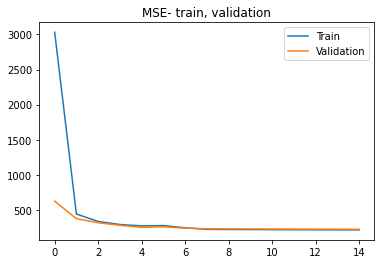

In [279]:
plt.plot(results['mse_train'], label="Train")
plt.plot(results['mse_val'], label= "Validation")
plt.legend()
plt.title('MSE- train, validation')
plt.show()

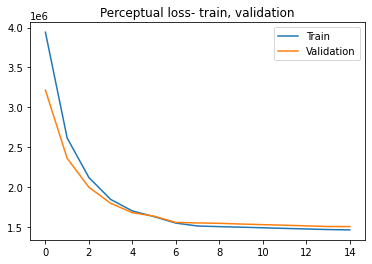

In [280]:
plt.plot(results['perceptual_loss_train'], label="Train")
plt.plot(results['perceptual_loss_val'], label= "Validation")
plt.legend()
plt.title('Perceptual loss- train, validation')
plt.show()

In [283]:
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)
labels = labels.to(device)
y_pred = model(inputs)

fig, axes = plt.subplots(inputs.shape[0], 3, figsize=(20, 80))

for i in range(inputs.shape[0]):
  truth = torchvision.utils.make_grid(labels.cpu()[i], nrow=1)
  truth = truth.permute(1, 2, 0).detach().numpy()
  input = torchvision.utils.make_grid(inputs.cpu()[i], nrow=1)
  input = input.permute(1, 2, 0).detach().numpy()
  pred = torchvision.utils.make_grid(y_pred.cpu()[i], nrow=1)
  pred = pred.permute(1, 2, 0).detach().numpy()
  #pred = (pred.permute(1, 2, 0).detach().numpy()*255).astype(np.uint8)

  axes[i,0].imshow(truth)
  axes[i,0].set_title("Ground Truth")
  axes[i,1].imshow(input)
  axes[i,1].set_title("Input")
  axes[i,2].imshow(pred)
  axes[i,2].set_title("Predicted")
plt.show()

Output hidden; open in https://colab.research.google.com to view.